In [13]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, balanced_accuracy_score, f1_score, accuracy_score, roc_auc_score, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt

# Read the data from the parquet file
df = pd.read_csv('../../data/heart_failure/train_val_split.csv')
df_test = pd.read_csv('../../data/heart_failure/test_split.csv')


numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
def set_seed(seed):
    torch.manual_seed(seed)  # Sets the seed for CPU operations
    torch.cuda.manual_seed(seed)  # Sets the seed for CUDA GPU operations
    torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
    random.seed(seed)  # Python's random library
    np.random.seed(seed)  # NumPy
    
    # For determinism in certain CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
set_seed(42)

## Preprocessing

In [15]:
df_clean = df.copy()
    
    
for col in numeric_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
        
    # Define bounds
    lower_bound = Q1 - (2 * IQR)
    upper_bound = Q3 + (2 * IQR)
        
    # Create mask for values within bounds
    mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
        
    # Apply mask
    df_clean = df_clean[mask]


display(df_clean)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [16]:
df_clean=pd.get_dummies(df_clean, columns=['ChestPainType','ST_Slope','RestingECG', 'Sex', 'ExerciseAngina'], drop_first=False, dtype=int)
df_test=pd.get_dummies(df_test, columns=['ChestPainType','ST_Slope','RestingECG', 'Sex', 'ExerciseAngina'], drop_first=False, dtype=int)

display(df_clean)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
1,37,130,283,0,98,0.0,0,0,1,0,...,0,0,1,0,0,1,0,1,1,0
2,48,138,214,0,108,1.5,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
3,54,150,195,0,122,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
4,39,120,339,0,170,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,0,182,0.0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
730,57,140,241,0,123,0.2,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
731,45,110,264,0,132,1.2,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
732,68,144,193,1,141,3.4,1,1,0,0,...,0,1,0,0,1,0,0,1,1,0


In [17]:
y = df_clean['HeartDisease']
X = df_clean.drop(['HeartDisease'], axis=1)

y_test = df_test['HeartDisease']
X_test = df_test.drop(['HeartDisease'], axis=1)

display(X)
display(y)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,172,0.0,0,1,0,0,0,0,1,0,1,0,0,1,1,0
1,37,130,283,0,98,0.0,0,1,0,0,0,0,1,0,0,1,0,1,1,0
2,48,138,214,0,108,1.5,1,0,0,0,0,1,0,0,1,0,1,0,0,1
3,54,150,195,0,122,0.0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
4,39,120,339,0,170,0.0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,0,182,0.0,0,1,0,0,0,0,1,0,1,0,0,1,1,0
730,57,140,241,0,123,0.2,1,0,0,0,0,1,0,0,1,0,1,0,0,1
731,45,110,264,0,132,1.2,0,0,0,1,0,1,0,0,1,0,0,1,1,0
732,68,144,193,1,141,3.4,1,0,0,0,0,1,0,0,1,0,0,1,1,0


0      0
1      0
2      1
3      0
4      0
      ..
729    0
730    1
731    1
732    1
733    1
Name: HeartDisease, Length: 719, dtype: int64

In [18]:
scaler = StandardScaler()

# Make a copy of the entire training data
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Scale test data using the same scaler
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


# Wrap in TensorDataset
train_dataset = TensorDataset(
    torch.tensor(X_scaled.values), 
    torch.tensor(y.values)
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

## Training

We use same parameters to allow for a fair comarison

In [19]:
# Neural Additive Model (NAM)
class NAM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(NAM, self).__init__()
        self.nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            ) for _ in range(input_dim)
        ])

    def forward(self, x):
        # Each subnetwork handles one input feature
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.nets)]
        return torch.sum(torch.cat(outputs, dim=1), dim=1)

In [20]:
# Instantiate model
model = NAM(input_dim=X_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch.float())  # raw logits
        loss = criterion(outputs, y_batch.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.4f}")

Epoch 0 | Loss: 59.9863
Epoch 10 | Loss: 31.1488
Epoch 20 | Loss: 28.2504
Epoch 30 | Loss: 27.1846
Epoch 40 | Loss: 26.6676
Epoch 50 | Loss: 26.5009
Epoch 60 | Loss: 26.2074
Epoch 70 | Loss: 26.2370
Epoch 80 | Loss: 25.9964
Epoch 90 | Loss: 25.9094


In [21]:
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_scaled.values).to(device).float())
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).int()
    
y_pred = y_pred.cpu().numpy()

    
# Calculate metrics
# Calculate metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auroc = roc_auc_score(y_test, y_pred)
auprc = average_precision_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {auroc:.4f}")
print(f"PRC AUC Score: {auprc:.4f}")

              precision    recall  f1-score   support

           0       0.82      0.76      0.79        74
           1       0.84      0.89      0.87       110

    accuracy                           0.84       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.84      0.84      0.84       184

Balanced Accuracy: 0.8238
F1 Score: 0.8673
ROC AUC Score: 0.8238
PRC AUC Score: 0.8179


## Visualizing Feature Importance

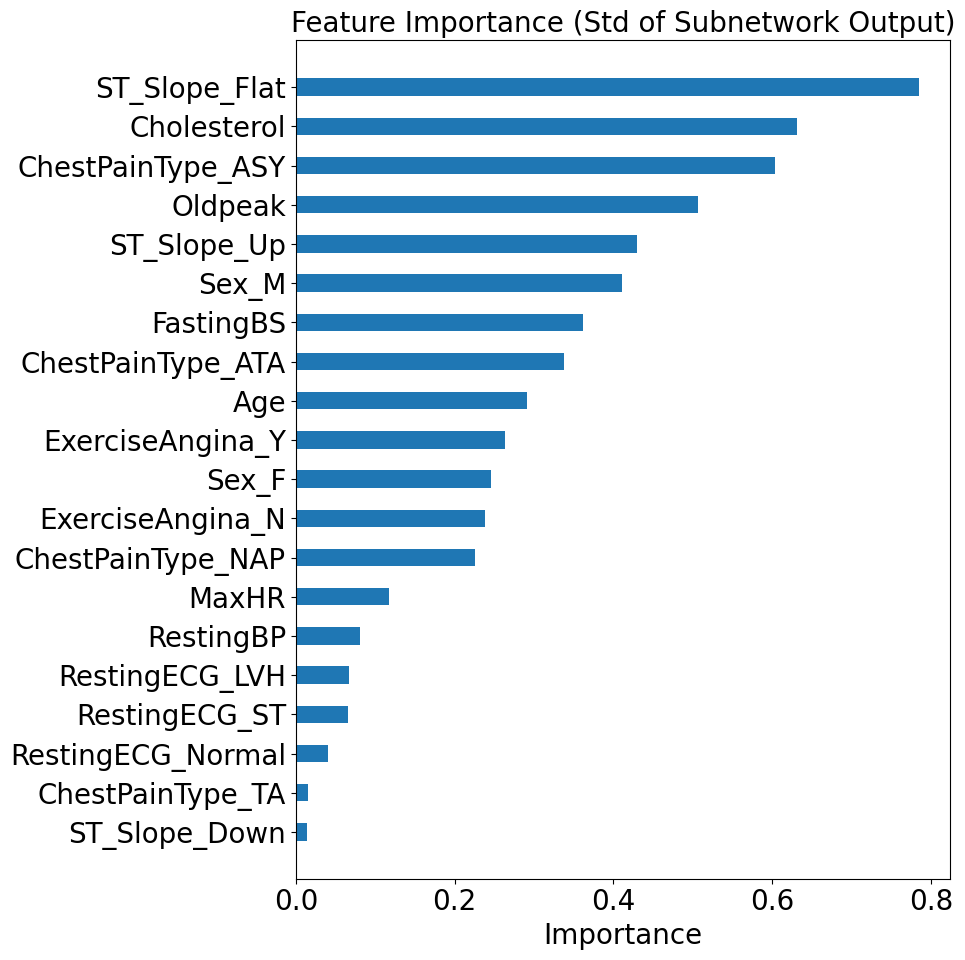

In [22]:
plt.rcParams.update({'font.size': 20})
feature_importance = {}

with torch.no_grad():
    for i, net in enumerate(model.nets):
        x_feat = torch.tensor(X_scaled.iloc[:, i].values.reshape(-1, 1), dtype=torch.float32).to(device)
        f_x = net(x_feat).cpu().numpy().flatten()
        feature_importance[X_scaled.columns[i]] = np.std(f_x)

importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['importance'])
importance_df.sort_values(by='importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 10))  # Taller figure for spacing
y_pos = np.arange(len(importance_df)) * 1.8  # Increase vertical spacing

ax.barh(y_pos, importance_df['importance'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(importance_df.index, fontsize=20)

ax.set_title("Feature Importance (Std of Subnetwork Output)", fontsize=20)
ax.set_xlabel("Importance", fontsize=20)
ax.invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

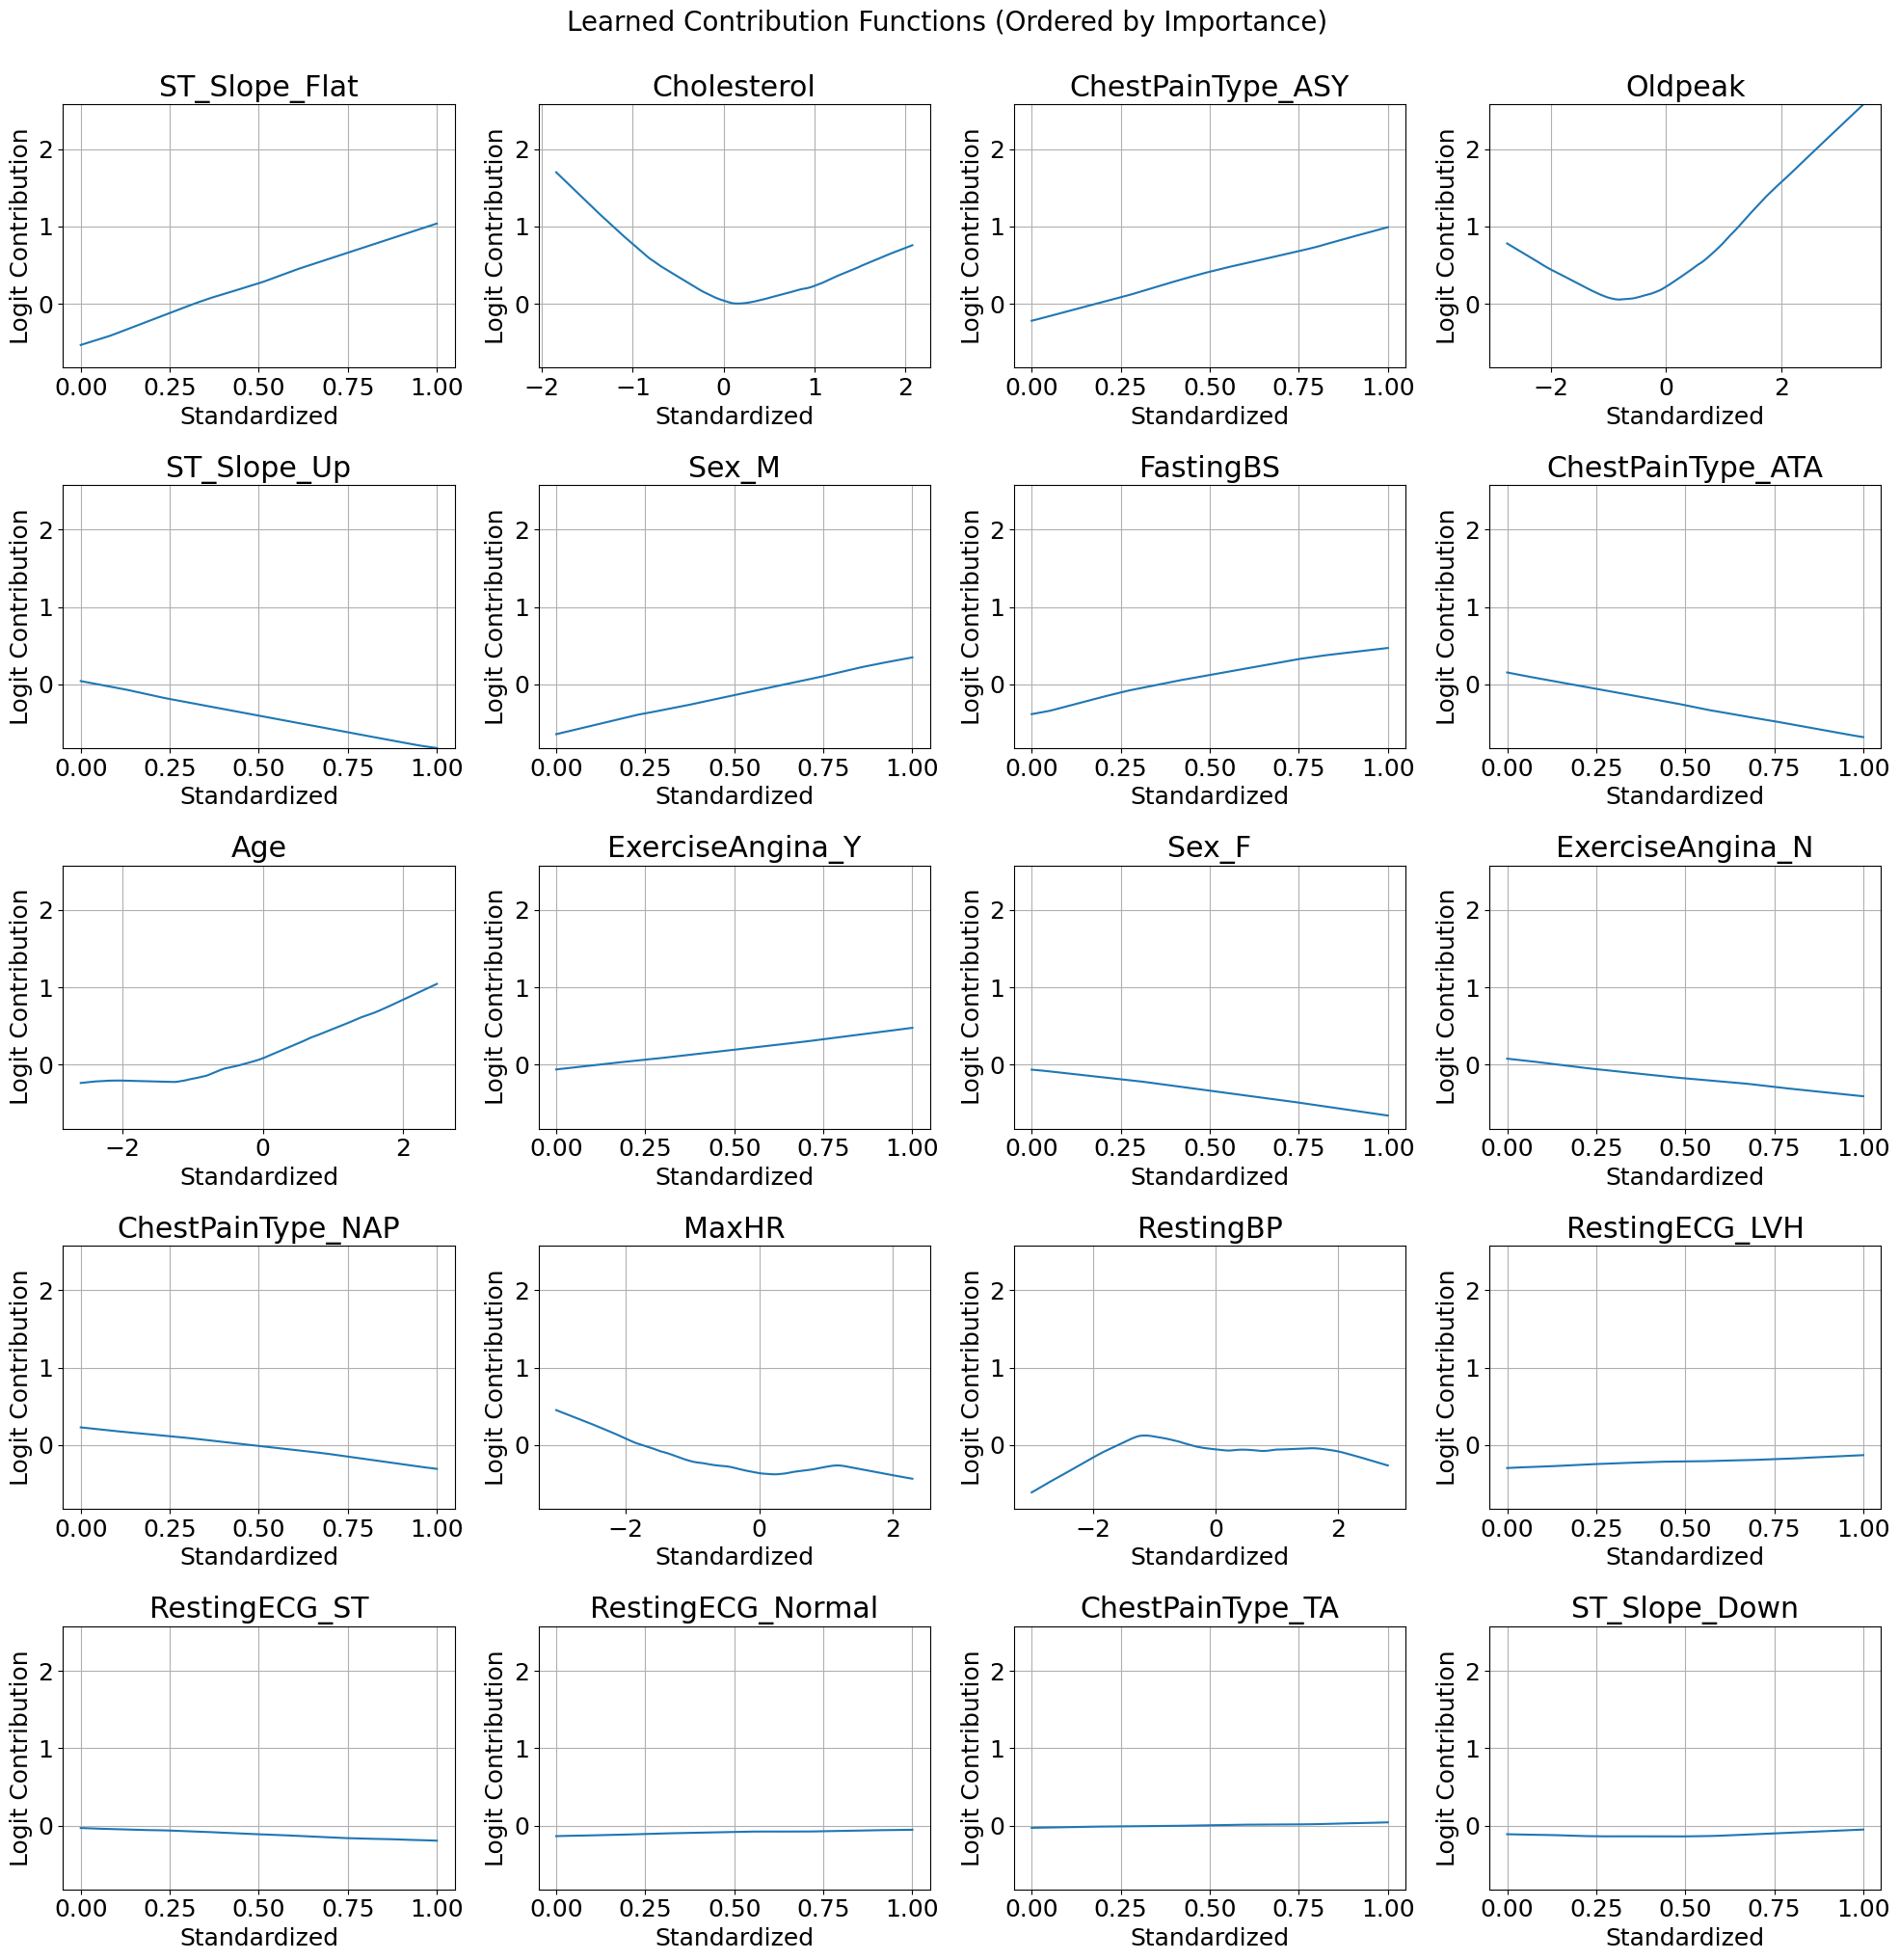

In [23]:
plt.rcParams.update({'font.size': 18})

only_top_row = False  # Set to False to show all features

# Get feature order by importance
ordered_features = importance_df.index.tolist()

# Limit to top row if specified
n_cols = 4
if only_top_row:
    ordered_features = ordered_features[:n_cols]

n_features = len(ordered_features)
n_rows = 1 if only_top_row else int(np.ceil(len(importance_df) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

model.eval()

# Calculate global y-axis limits
y_min, y_max = float('inf'), float('-inf')
for feat in ordered_features:
    i = X_scaled.columns.get_loc(feat)
    x_vals = np.linspace(X_scaled.iloc[:, i].min(), X_scaled.iloc[:, i].max(), 100).reshape(-1, 1)
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_vals = model.nets[i](x_tensor).cpu().numpy().flatten()
    y_min = min(y_min, y_vals.min())
    y_max = max(y_max, y_vals.max())

# Plot each feature in importance order
for idx, feat in enumerate(ordered_features):
    i = X_scaled.columns.get_loc(feat)
    x_vals = np.linspace(X_scaled.iloc[:, i].min(), X_scaled.iloc[:, i].max(), 100).reshape(-1, 1)
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_vals = model.nets[i](x_tensor).cpu().numpy().flatten()

    ax = axes[idx]
    ax.plot(x_vals, y_vals)
    ax.set_title(f"{feat}")
    ax.set_xlabel("Standardized")
    ax.set_ylabel("Logit Contribution")
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

# Hide unused subplots
for j in range(n_features, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.suptitle("Learned Contribution Functions (Ordered by Importance)", fontsize=20, y=1.02)
plt.show()
